<span style ="font-size:35px;"> **Operações e Serviços** </span> 

<span style ="font-size:30px;"> **Binary Classification for Customer Satisfaction** </span> <div>

### **Logistic Regression Model (22 variables)**
***


### **Libraries**
***

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

### **Loading the data** 
***

In [7]:
train_data = pd.read_excel('C:/Users/USER/Downloads/Passanger_Satisfaction_survey_dataset_GRUPO.xlsx', 
                           sheet_name='Train_Satisfaction_binomial')

test_data = pd.read_excel('C:/Users/USER/Downloads/Passanger_Satisfaction_survey_dataset_GRUPO.xlsx', 
                          sheet_name='Test_Satisfaction_binomial')

# target
target_column = 'satisfaction_v2'

# Split features and target in the training set
X_train = train_data.drop(columns=[target_column])  
y_train = train_data[target_column]  

# Split features and target in the testing set
X_test = test_data.drop(columns=[target_column]) 
y_test = test_data[target_column]  

# Filtrar apenas as colunas normalizadas no conjunto de treino e teste
normalized_columns = [col for col in X_train.columns if col.startswith('normalized_')]

# Remover variáveis específicas
vars_to_remove = [
    'normalized_satisfaction_v2',
]
normalized_columns = [col for col in normalized_columns if col not in vars_to_remove]

X_train_normalized = X_train[normalized_columns]
X_test_normalized = X_test[normalized_columns]

# Converter para NumPy arrays
X_train_array = X_train_normalized.to_numpy()
X_test_array = X_test_normalized.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Verificar os shapes
print("Shape de X_train_array:", X_train_array.shape)
print("Shape de X_test_array:", X_test_array.shape)
print("Shape de y_train_array:", y_train_array.shape)
print("Shape de y_test_array:", y_test_array.shape)

# Verificar os 10 primeiros exemplos no formato NumPy
print("Primeiros 10 exemplos de X_train_array:")
print(X_train_array[:10])
print("Primeiros 10 valores de y_train_array:")
print(y_train_array[:10])


Shape de X_train_array: (103589, 22)
Shape de X_test_array: (25898, 22)
Shape de y_train_array: (103589,)
Shape de y_test_array: (25898,)
Primeiros 10 exemplos de X_train_array:
[[1.00000000e+00 0.00000000e+00 5.25641026e-01 1.00000000e+00
  1.00000000e+00 3.13143023e-01 6.00000000e-01 6.00000000e-01
  6.00000000e-01 6.00000000e-01 1.00000000e+00 6.00000000e-01
  1.00000000e+00 1.00000000e+00 6.00000000e-01 4.00000000e-01
  1.00000000e+00 8.00000000e-01 1.00000000e+00 1.00000000e+00
  1.25628141e-03 3.15656566e-03]
 [1.00000000e+00 1.00000000e+00 5.51282051e-01 1.00000000e+00
  1.00000000e+00 2.72714099e-01 4.00000000e-01 4.00000000e-01
  4.00000000e-01 4.00000000e-01 8.00000000e-01 8.00000000e-01
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 6.00000000e-01 1.00000000e+00 8.00000000e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 5.38461538e-01 1.00000000e+00
  1.00000000e+00 5.01666425e-01 6.00000000e-01 6.00000000e-01
  6.00000000

### **Sigmoid function**
***

In [8]:
def sigmoid(z):

    g = 1/(1+np.exp(-z))
   
    return g

### **Cost Function**
***

In [34]:
def compute_cost_logistic(X, y, w, b):
    m,n  = X.shape
    cost = 0.
    for i in range(m):
        z_i = np.dot(X[i], w) + b                                      #(n,)(n,)=scalar, see np.dot
        f_wb_i = sigmoid(z_i)                                          #scalar
        cost +=  -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)      #scalar
             
    cost = cost/m                                                      #scalar


    return cost  

### **Logistic Gradient Descent**
***

In [36]:
def compute_gradient_logistic(X, y, w, b): 
    m,n = X.shape
    dj_dw = np.zeros((n,))                            #(n,)
    dj_db = 0.0                                       #scalar

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar


    return dj_db, dj_dw  

def gradient_descent(X, y, w_in, b_in, alpha, num_iters):
    J_history = []
    accuracies = []  # Histórico da accuracy
    precisions = []  # Histórico da precisão

    w = copy.deepcopy(w_in)
    b = b_in

    for i in range(num_iters):
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        J_history.append(compute_cost_logistic(X, y, w, b))
        
        if i % 100 == 0:
            y_pred = sigmoid(np.dot(X, w) + b) >= 0.5  # Predição binária
            accuracy = np.mean(y_pred == y)  # Comparar predições com o target
            precision = precision_score(y, y_pred)  # Calcular precisão
            accuracies.append(accuracy)
            precisions.append(precision)
            print(f"Iteration {i:4d}: Cost {J_history[-1]:.10f}, Accuracy {accuracy:.10f}, Precision {precision:.10f}")
    
    return w, b, J_history, accuracies, precisions

In [44]:
# Configurações do modelo
w_tmp = np.zeros_like(X_train_array[0])  # Pesos iniciais
b_tmp = 0.0  # Bias inicial
alpha = 0.1  # Taxa de aprendizado
iters = 3200  # Número de iterações

# Medir o tempo de execução
start_time = time.time()  # Registrar o tempo inicial

# Treinamento do modelo
w_out, b_out, J_history, accuracies, precisions = gradient_descent(
    X_train_array, y_train_array, w_tmp, b_tmp, alpha, iters
)

end_time = time.time()  # Registrar o tempo final

# Calcular o tempo total de execução
elapsed_time = end_time - start_time

# Exibir os parâmetros finais
print(f"\nUpdated parameters: w:{w_out}, b:{b_out}")

# Exibir o último valor de Accuracy e Precision
final_accuracy = accuracies[-1] if accuracies else None
final_precision = precisions[-1] if precisions else None

print(f"Final Accuracy: {final_accuracy:.4f}")
print(f"Final Precision: {final_precision:.4f}")

# Exibir o tempo total de execução
print(f"Elapsed Time for Training: {elapsed_time:.2f} seconds")



Iteration    0: Cost 0.6848715611, Accuracy 0.5470175405, Precision 0.5470175405
Iteration  100: Cost 0.5790051352, Accuracy 0.7330894207, Precision 0.6879810309
Iteration  200: Cost 0.5352944887, Accuracy 0.7692998291, Precision 0.7367249924
Iteration  300: Cost 0.5099459156, Accuracy 0.7812991727, Precision 0.7565011464
Iteration  400: Cost 0.4928090366, Accuracy 0.7893309135, Precision 0.7691749073
Iteration  500: Cost 0.4801264554, Accuracy 0.7947948141, Precision 0.7778056741
Iteration  600: Cost 0.4702018352, Accuracy 0.7987624169, Precision 0.7842552178
Iteration  700: Cost 0.4621431900, Accuracy 0.8022666499, Precision 0.7898734177
Iteration  800: Cost 0.4554262736, Accuracy 0.8054040487, Precision 0.7945110441
Iteration  900: Cost 0.4497170993, Accuracy 0.8080394636, Precision 0.7982871602
Iteration 1000: Cost 0.4447899037, Accuracy 0.8105783433, Precision 0.8019530804
Iteration 1100: Cost 0.4404851131, Accuracy 0.8123835542, Precision 0.8046844311
Iteration 1200: Cost 0.43668

### **Variables Impact**
***


Impacto das Features:
                                         Feature    Weight  Absolute Weight
11             normalized_Inflight entertainment  2.618427         2.618427
13             normalized_Ease of Online booking  1.420762         1.420762
1                       normalized_Customer Type  1.316340         1.316340
5                     normalized_Flight Distance  1.177128         1.177128
6                        normalized_Seat comfort  1.130783         1.130783
14                   normalized_On-board service  1.041047         1.041047
4                               normalized_Class  0.994935         0.994935
0                              normalized_Gender  0.950835         0.950835
7   normalized_Departure/Arrival time convenient  0.896420         0.896420
17                    normalized_Checkin service  0.812356         0.812356
2                                 normalized_Age  0.787907         0.787907
15                   normalized_Leg room service  0.624312       

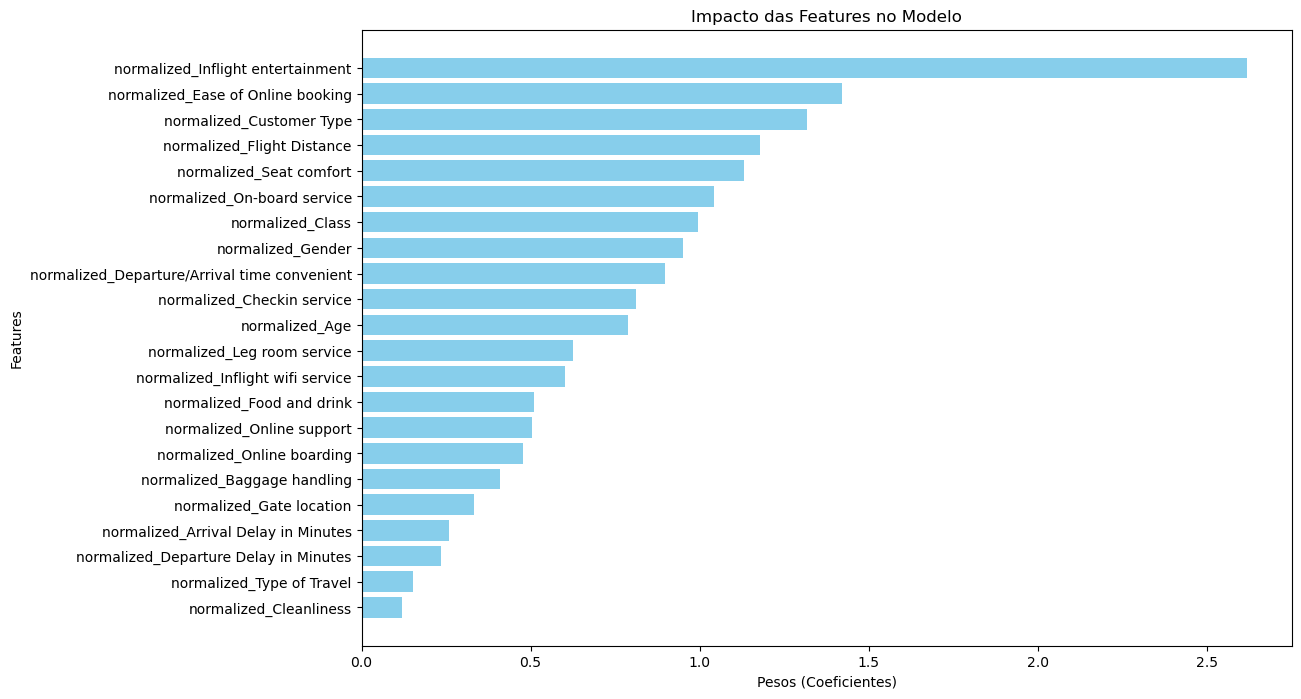

In [10]:
# Ajustar o impacto das features para valores absolutos
adjusted_weights = np.abs(w_out)  # Torna todos os valores absolutos

# Criar a tabela ajustada
adjusted_feature_impact = pd.DataFrame({
    "Feature": normalized_columns,
    "Weight": adjusted_weights
})

# Ordenar pelo impacto absoluto
adjusted_feature_impact["Absolute Weight"] = adjusted_feature_impact["Weight"]
adjusted_feature_impact = adjusted_feature_impact.sort_values(
    by="Absolute Weight", ascending=False
)

# Exibir o impacto ajustado
print("\nImpacto das Features:")
print(adjusted_feature_impact)

# Plotar impacto ajustado das features
plt.figure(figsize=(12, 8))
plt.barh(adjusted_feature_impact["Feature"], adjusted_feature_impact["Weight"], color="skyblue")
plt.xlabel("Pesos (Coeficientes)")
plt.ylabel("Features")
plt.title("Impacto das Features no Modelo")
plt.gca().invert_yaxis()  # Inverter ordem para maior impacto no topo
plt.show()


### **Model Evolution**
***

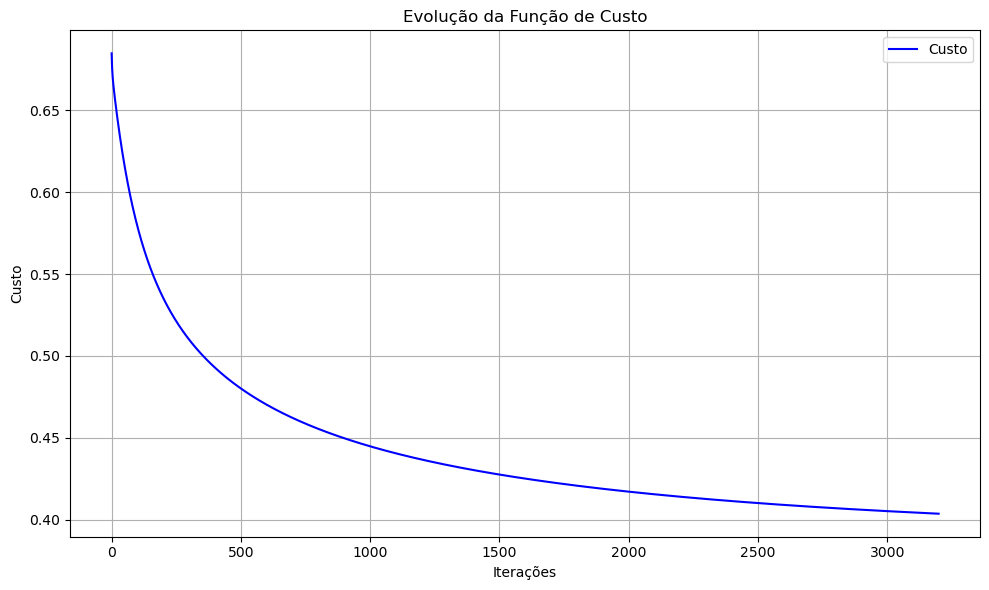

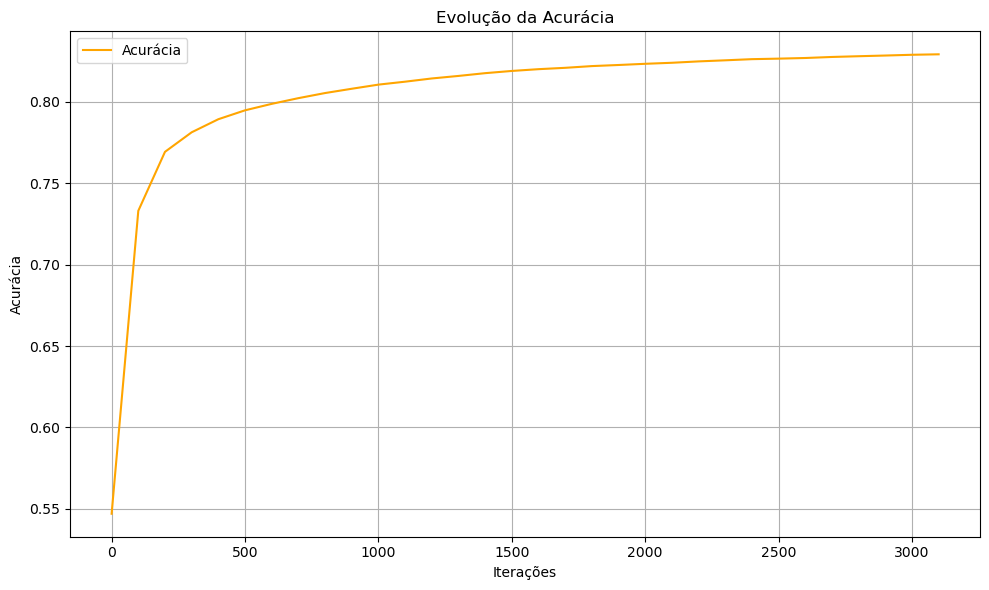

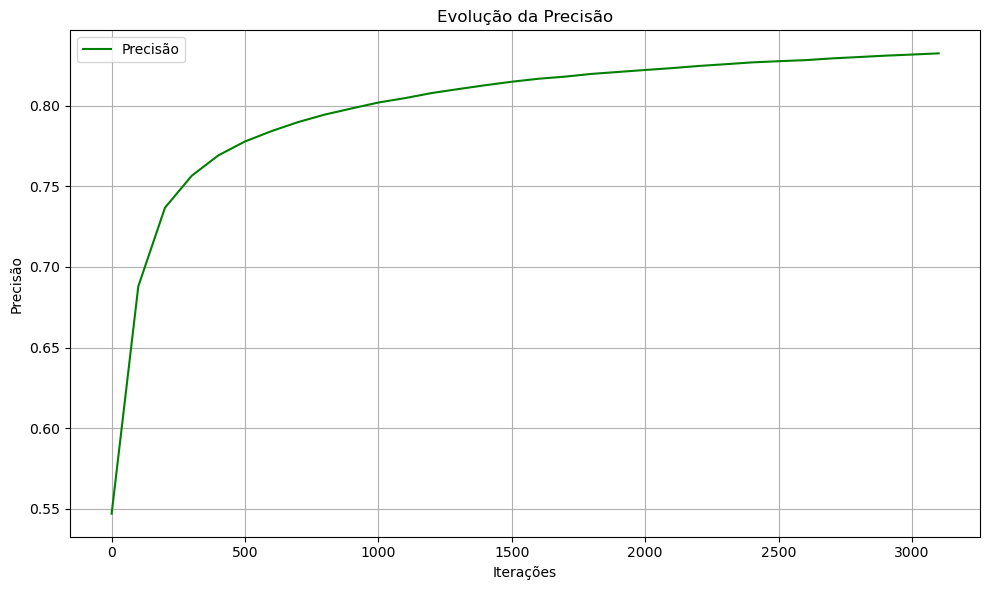

In [40]:
# Plotar evolução da função de custo
plt.figure(figsize=(10, 6))
plt.plot(range(len(J_history)), J_history, label='Custo', color='blue')
plt.xlabel('Iterações')
plt.ylabel('Custo')
plt.title('Evolução da Função de Custo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar evolução da acurácia
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(accuracies) * 100, 100), accuracies, label='Acurácia', color='orange')
plt.xlabel('Iterações')
plt.ylabel('Acurácia')
plt.title('Evolução da Acurácia')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotar evolução da precisão
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(precisions) * 100, 100), precisions, label='Precisão', color='green')
plt.xlabel('Iterações')
plt.ylabel('Precisão')
plt.title('Evolução da Precisão')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### **Predictions | test data** 
***

In [9]:
### Creating the output variables (weights) so we do not need to train the model again when restarting kernel
w_out = np.array([-0.95083516,  1.31634035, -0.78790734,  0.15078582,  0.9949355, 
                  -1.17712833,  1.13078266, -0.89642032, -0.51009516, -0.3320647, 
                  -0.60113127,  2.61842674,  0.50288091,  1.42076169,  1.04104743, 
                   0.6243124,   0.4093937,   0.81235582, -0.11839338,  0.47680737, 
                  -0.23442968, -0.2576448])

b_out = -4.785696844066806

# Função para prever valores
def predict(X, w, b):
    z = np.dot(X, w) + b  # Calcular z
    y_pred = sigmoid(np.dot(X,w) + b)  # Aplicar sigmoid
    return np.where(y_pred >= 0.5, 1, 0)  # Converter para 0 ou 1 (threshold 0.5)

# Previsões no conjunto de teste
y_test_pred = predict(X_test_array, w_out, b_out)
print("Primeiras 10 previsões do conjunto de teste:", y_test_pred[:10])
print("Shape das previsões:", y_test_pred.shape)

Primeiras 10 previsões do conjunto de teste: [1 1 1 1 0 1 1 1 1 1]
Shape das previsões: (25898,)
